## Hybrid Approach with **lstm + GRU**

LSTM captures long-term dependencies, followed by a GRU layer to refine the sequential features with lower computational cost.

Dropout layers for regularization,Binary classification with sigmoid activation

*Flow/Architecture*

LSTM LAYER → Dropout → GRU Layer → Dropout → Dense Layers

In [ ]:
#Load all libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

# Set display options for pandas
display_options = {
    'display.max_columns': None,
    'display.width': 1000,
}
for option, value in display_options.items():
    pd.set_option(option, value)

# Set seaborn style for visualization
sns.set_style("darkgrid")

# Check TensorFlow and Keras versions
# Check TensorFlow and Keras versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.version.VERSION)


TensorFlow version: 2.18.0
Keras version: 2.18.0


In [ ]:
# Load dataset
# Step 2: Load the phishing website dataset
dataset_path = "/content/dataset_full.csv"
data = pd.read_csv(dataset_path)

# Display basic information about the dataset
print("Dataset loaded successfully!")
print("Dataset shape:", data.shape)
print("First five rows:")
print(data.head())

Dataset loaded successfully!
Dataset shape: (88647, 112)
First five rows:
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url  qty_tld_url  length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_

In [ ]:
# Step 3: Preprocess the dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Handle missing values
data = data.dropna()

# Remove duplicate rows
data = data.drop_duplicates()

# Convert boolean features to integer
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

# Identify numerical columns
numerical_columns = [col for col in data.columns if col not in boolean_columns]

# Standardize numerical features using StandardScaler
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])

# Normalize numerical features using MinMaxScaler
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

# Save the cleaned dataset as newphishdata.csv
cleaned_dataset_path = "newphishdata.csv"
data.to_csv(cleaned_dataset_path, index=False)

print("Dataset preprocessing completed. Cleaned dataset saved as", cleaned_dataset_path)



<ipython-input-3-40d0bd05b13f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[boolean_columns] = data[boolean_columns].astype(int)


Dataset preprocessing completed. Cleaned dataset saved as newphishdata.csv



Summary Statistics:
        qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url    qty_at_url   qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url   qty_tld_url    length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_comma_directory  qty_plus_d

<ipython-input-4-69696e36bbf0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='phishing', data=data, palette='coolwarm')


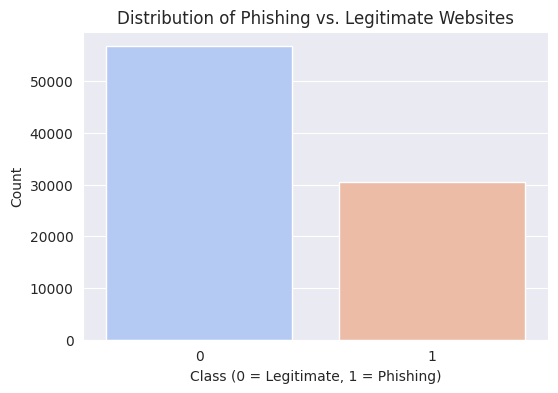

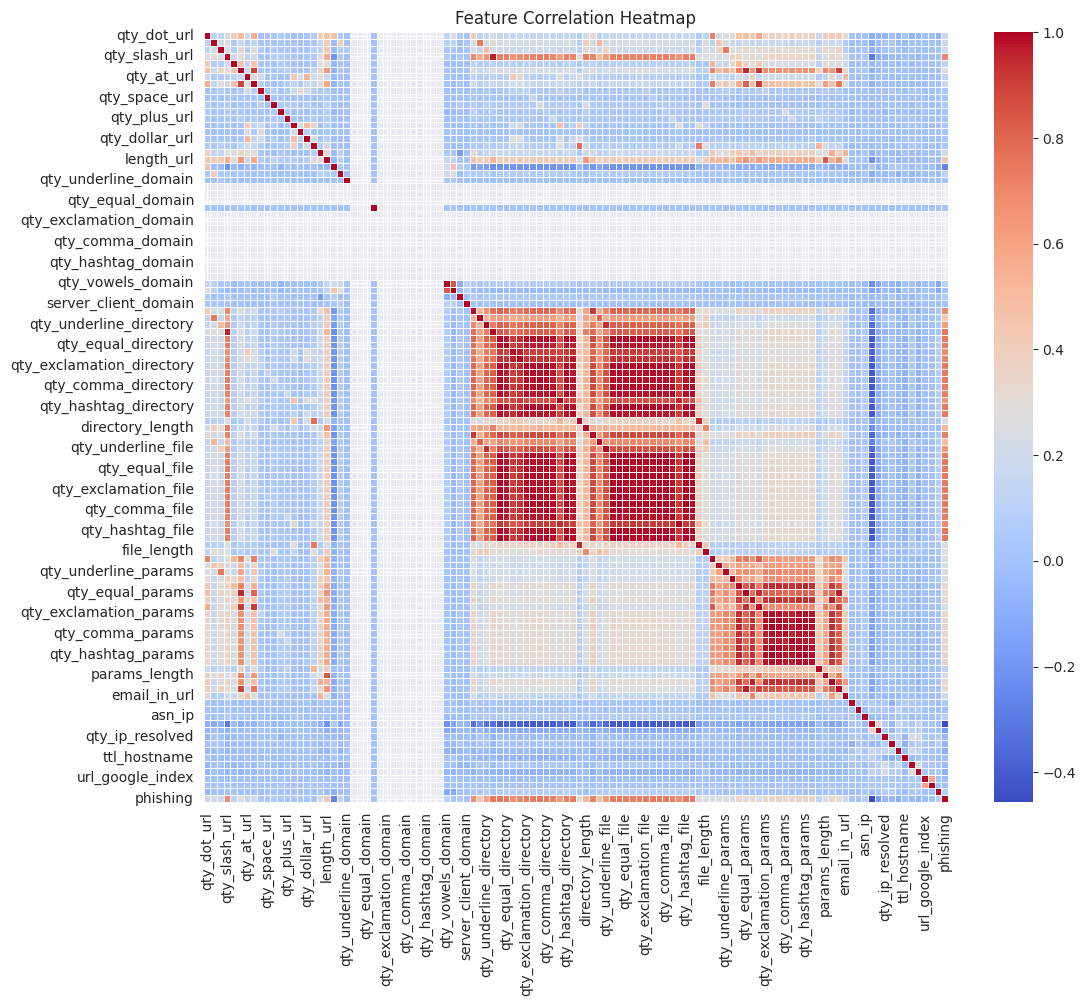

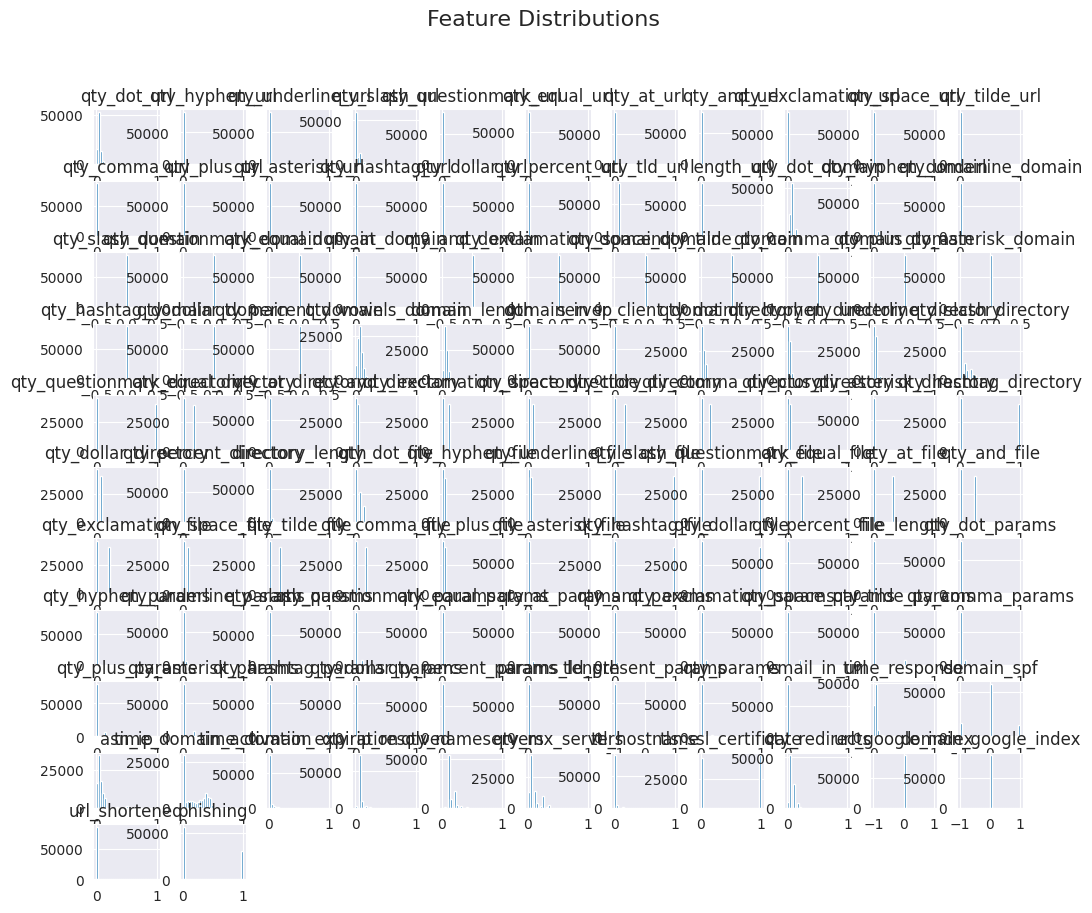

In [ ]:
# Step 4: Exploratory Data Analysis (EDA)
# Display summary statistics
print("\nSummary Statistics:")
print(data.describe())

# Plot distribution of phishing vs. legitimate websites
plt.figure(figsize=(6,4))
sns.countplot(x='phishing', data=data, palette='coolwarm')
plt.title("Distribution of Phishing vs. Legitimate Websites")
plt.xlabel("Class (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Visualize feature distributions
data.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [ ]:
#  Step 4.5: Balance the dataset (Downsampling)
from sklearn.utils import resample

# Separate phishing (1) and legitimate (0) samples
phishing = data[data['phishing'] == 1]
legitimate = data[data['phishing'] == 0]

# Downsample legitimate samples to match phishing count
legitimate_downsampled = resample(legitimate,
                                  replace=False,  # No duplication
                                  n_samples=len(phishing),  # Match phishing count
                                  random_state=42)

# Combine balanced dataset
balanced_data = pd.concat([phishing, legitimate_downsampled])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", balanced_data.shape)

#  Now replace "data" with "balanced_data" in the train-test split
X = balanced_data.drop(columns=['phishing'])  # Features
y = balanced_data['phishing']  # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Balanced dataset shape: (60994, 112)


In [ ]:
# Step 5: Split the dataset into training (80%) and testing (20%) sets
X = data.drop(columns=['phishing'])  # Features
y = data['phishing']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



print("Dataset successfully split into training and testing sets.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Dataset successfully split into training and testing sets.
Training set shape: (69767, 111)
Testing set shape: (17442, 111)


In [ ]:
print("Training set shape:", X_train.shape)  # Should be (num_samples, 111)
print("Testing set shape:", X_test.shape)  # Should be (num_samples, 111)


Training set shape: (69767, 111)
Testing set shape: (17442, 111)


In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Reshape

# Reshape data for LSTM-GRU input (samples, timesteps, features)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the LSTM + GRU Hybrid model
hybrid_model = Sequential()

# LSTM Layer (First Stage)
hybrid_model.add(LSTM(units=64, return_sequences=True, input_shape=(1, X_train.shape[2])))
hybrid_model.add(Dropout(0.2))

# GRU Layer (Second Stage)
hybrid_model.add(GRU(units=32, return_sequences=False))
hybrid_model.add(Dropout(0.2))

# Fully Connected Layers
hybrid_model.add(Dense(64, activation='relu'))
hybrid_model.add(Dropout(0.2))
hybrid_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
hybrid_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Model summary
hybrid_model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM + GRU model
history_hybrid = hybrid_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          45,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - AUC: 0.9506 - Precision: 0.8243 - Recall: 0.8804 - accuracy: 0.8942 - loss: 0.2666 - val_AUC: 0.9791 - val_Precision: 0.8996 - val_Recall: 0.8936 - val_accuracy: 0.9279 - val_loss: 0.1784
Epoch 2/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.9759 - Precision: 0.8749 - Recall: 0.9111 - accuracy: 0.9232 - loss: 0.1881 - val_AUC: 0.9801 - val_Precision: 0.8942 - val_Recall: 0.9101 - val_accuracy: 0.9309 - val_loss: 0.1714
Epoch 3/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - AUC: 0.9772 - Precision: 0.8782 - Recall: 0.9103 - accuracy: 0.9239 - loss: 0.1821 - val_AUC: 0.9811 - val_Precision: 0.9160 - val_Recall: 0.8760 - val_accuracy: 0.9286 - val_loss: 0.1712
Epoch 4/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - AUC: 0.9780 - Precision: 0.8816 - Recall: 0.9087 - accuracy: 0.9254 - loss: 0.1788 - val_AUC: 0.9815 - val_Precision: 0.8828 - val_Recall: 0.9300 - val_accuracy: 0.9323 - val_loss: 0.1658
Epoch 5/50
2181/2181

In [ ]:
# Predict labels
y_pred_hybrid = (hybrid_model.predict(X_test) > 0.5).astype(int)

# Compute evaluation metrics
accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid)
precision_hybrid = precision_score(y_test, y_pred_hybrid)
recall_hybrid = recall_score(y_test, y_pred_hybrid)
auc_hybrid = roc_auc_score(y_test, y_pred_hybrid)
conf_matrix_hybrid = confusion_matrix(y_test, y_pred_hybrid)

# Print results
print("\nLSTM + GRU Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_hybrid:.4f}")
print(f"Precision: {precision_hybrid:.4f}")
print(f"Recall: {recall_hybrid:.4f}")
print(f"AUC Score: {auc_hybrid:.4f}")
print("Confusion Matrix:")
print(conf_matrix_hybrid)

# Save training history
np.save("model_history_HYBRID.npy", history_hybrid.history)
hist_hybrid = np.load("model_history_HYBRID.npy", allow_pickle=True).item()


546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

LSTM + GRU Model Evaluation Metrics:
Accuracy: 0.9518
Precision: 0.9455
Recall: 0.9151
AUC Score: 0.9433
Confusion Matrix:
[[11021   322]
 [  518  5581]]


In [ ]:
# Extract values from confusion matrix
false_positives_hybrid = conf_matrix_hybrid[0][1]
false_negatives_hybrid = conf_matrix_hybrid[1][0]
true_negatives_hybrid = conf_matrix_hybrid[0][0]
true_positives_hybrid = conf_matrix_hybrid[1][1]

# Compute FAR & FRR
far_hybrid = false_positives_hybrid / (false_positives_hybrid + true_negatives_hybrid)  # FAR = FP / (FP + TN)
frr_hybrid = false_negatives_hybrid / (false_negatives_hybrid + true_positives_hybrid)  # FRR = FN / (FN + TP)

# Display FAR & FRR
print("\nLSTM + GRU False Acceptance Rate (FAR):", round(far_hybrid, 4))
print("LSTM + GRU False Rejection Rate (FRR):", round(frr_hybrid, 4))



LSTM + GRU False Acceptance Rate (FAR): 0.0284
LSTM + GRU False Rejection Rate (FRR): 0.0849


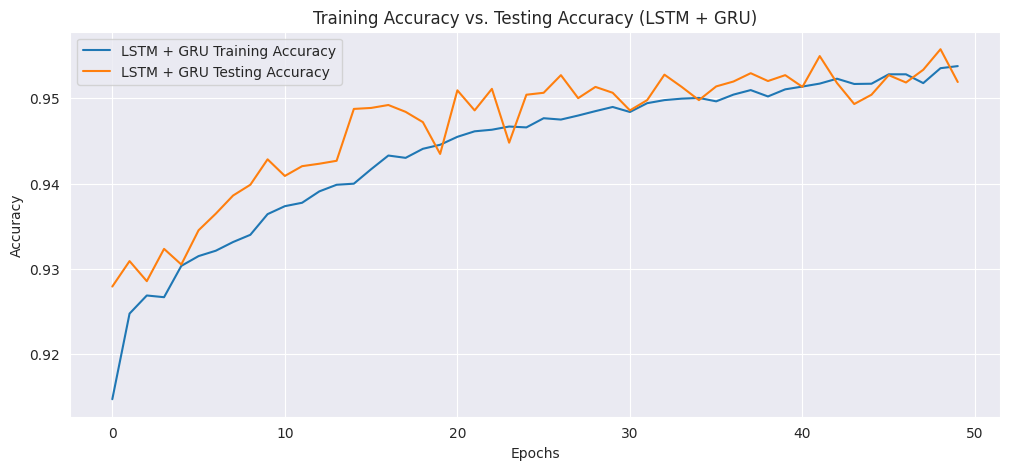

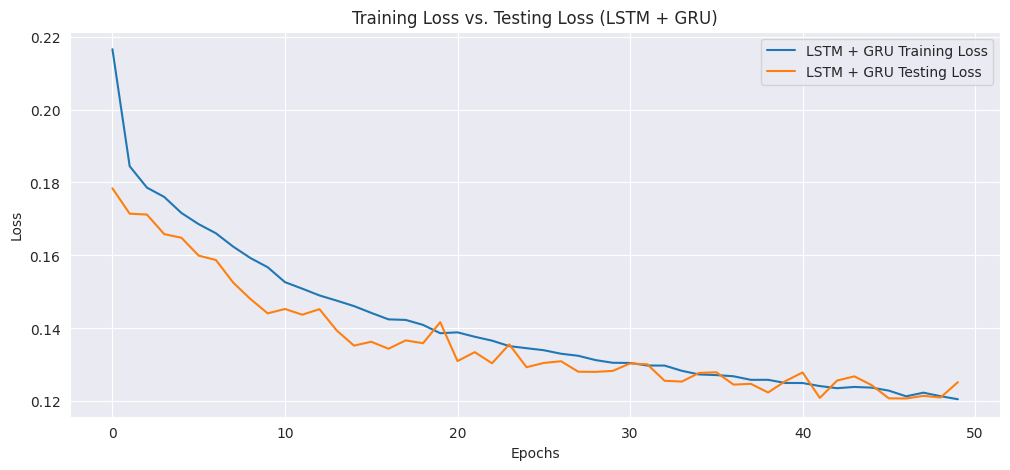

In [ ]:
# Step 10: Plot Training Accuracy vs. Testing Accuracy and Training Loss vs. Testing Loss for LSTM + GRU

# Plot Training Accuracy vs. Testing Accuracy for LSTM + GRU
plt.figure(figsize=(12, 5))
plt.plot(history_hybrid.history['accuracy'], label='LSTM + GRU Training Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='LSTM + GRU Testing Accuracy')
plt.title("Training Accuracy vs. Testing Accuracy (LSTM + GRU)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Training Loss vs. Testing Loss for LSTM + GRU
plt.figure(figsize=(12, 5))
plt.plot(history_hybrid.history['loss'], label='LSTM + GRU Training Loss')
plt.plot(history_hybrid.history['val_loss'], label='LSTM + GRU Testing Loss')
plt.title("Training Loss vs. Testing Loss (LSTM + GRU)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
